  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)


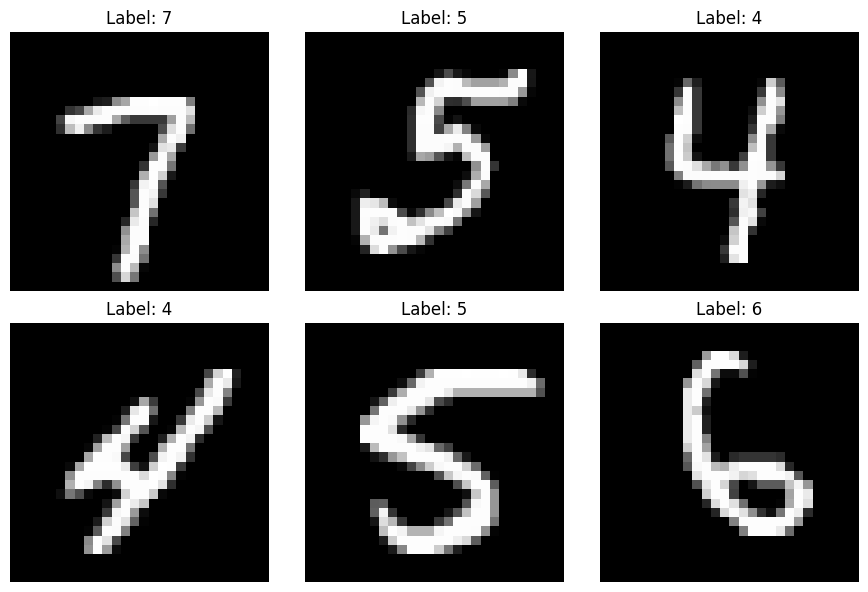

Using cpu device

Epoch 1/5
------------------------------
Batch 0: loss = 2.3158
Batch 200: loss = 0.2405
Batch 400: loss = 0.2955
Batch 600: loss = 0.1223
Batch 800: loss = 0.1810

Epoch 2/5
------------------------------
Batch 0: loss = 0.1588
Batch 200: loss = 0.1054
Batch 400: loss = 0.3182
Batch 600: loss = 0.0404
Batch 800: loss = 0.1564

Epoch 3/5
------------------------------
Batch 0: loss = 0.1737
Batch 200: loss = 0.0715
Batch 400: loss = 0.2144
Batch 600: loss = 0.0916
Batch 800: loss = 0.1643

Epoch 4/5
------------------------------
Batch 0: loss = 0.0281
Batch 200: loss = 0.0658
Batch 400: loss = 0.1233
Batch 600: loss = 0.0987
Batch 800: loss = 0.1123

Epoch 5/5
------------------------------
Batch 0: loss = 0.0177
Batch 200: loss = 0.0187
Batch 400: loss = 0.0740
Batch 600: loss = 0.0421
Batch 800: loss = 0.0836

Training complete!
Test Accuracy: 96.86%
Model saved as mnist_model.pth


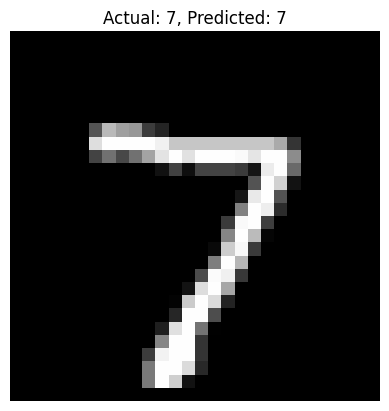

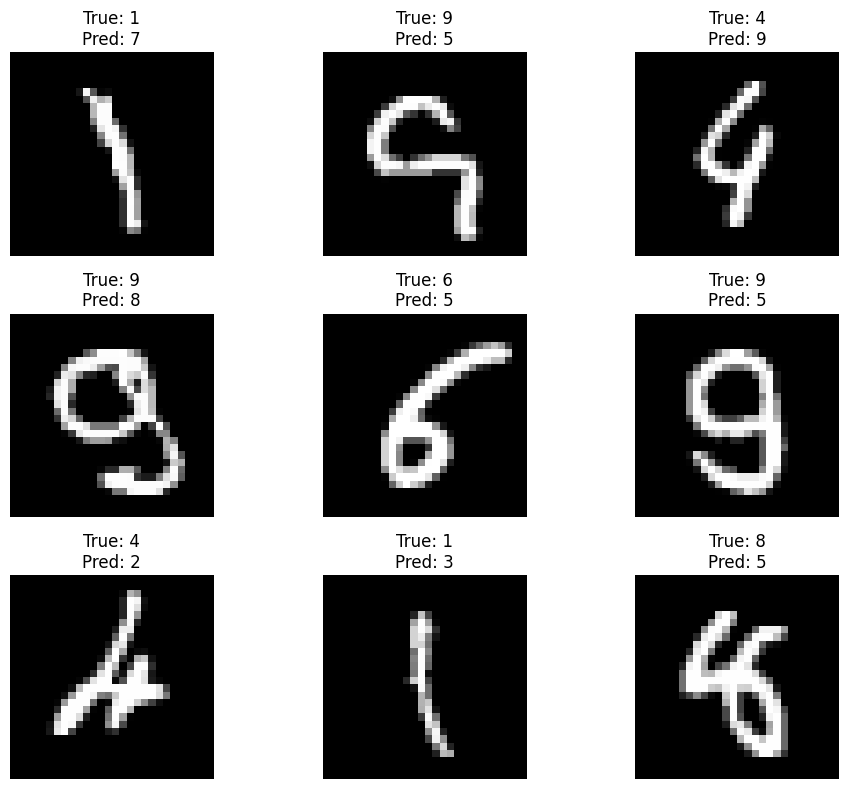

In [1]:
# Install dependencies
!pip install -r requirements.txt

# Import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from model import NeuralNet

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Image visualization function - CORRECTED
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    # FIXED: Properly closed parentheses
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

# Visualize training samples
images, labels = next(iter(train_loader))
plt.figure(figsize=(9, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i])
    plt.title(f'Label: {labels[i]}')
plt.tight_layout()
plt.savefig('training_samples.png')
plt.show()

# Initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNet().to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 200 == 0:
            print(f"Batch {batch}: loss = {loss.item():.4f}")

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 30)
    train(train_loader, model, loss_fn, optimizer)
print("\nTraining complete!")

# Evaluation function
def test(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate model
accuracy = test(test_loader, model)

# Save model
torch.save(model.state_dict(), 'mnist_model.pth')
print("Model saved as mnist_model.pth")

# Sample prediction
sample_idx = 0
sample_img, sample_label = test_data[sample_idx]
model.eval()
with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device))
    predicted = pred.argmax(1).item()

# Show prediction
plt.figure()
imshow(sample_img)
plt.title(f'Actual: {sample_label}, Predicted: {predicted}')
plt.savefig('sample_prediction.png')
plt.show()

# Find misclassifications
model.eval()
misclassified = []
with torch.no_grad():
    for i in range(len(test_data)):
        img, label = test_data[i]
        pred = model(img.unsqueeze(0).to(device))
        predicted = pred.argmax(1).item()
        if predicted != label:
            misclassified.append((img, label, predicted))
        if len(misclassified) >= 9:
            break

# Plot misclassifications
plt.figure(figsize=(10, 8))
for i, (img, true_label, pred_label) in enumerate(misclassified[:9]):
    plt.subplot(3, 3, i+1)
    imshow(img)
    plt.title(f'True: {true_label}\nPred: {pred_label}')
plt.tight_layout()
plt.savefig('misclassifications.png')
plt.show()

# Update README with accuracy
with open("README.md", "a") as f:
    f.write(f"\n## Results\n- Achieved Accuracy: {accuracy:.2f}%\n")
    f.write("![Training Samples](training_samples.png)\n")
    f.write("![Sample Prediction](sample_prediction.png)\n")
    f.write("![Misclassifications](misclassifications.png)\n")

# Git operations (optional)
# !git init
# !git add .
# !git commit -m "Completed training with {accuracy:.2f}% accuracy"
# !git push origin main